In [ ]:
!pip install rdkit scikit-learn pandas openpyxl matplotlib seaborn

In [ ]:
# === FULL SGLT2 PREDICTOR PIPELINE WITH SKLEARN ===
# Run this in a new Colab notebook. Upload your Excel via Drive mount.

# Cell 1: Installs & Imports


import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression  # Or use SVC for SVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Mount Drive for Excel
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 2: Load Data
file_path = "/content/drive/MyDrive/ALBERT/Pubchem_data_SGLT2_03112025.xlsx"  # Adjust path

sheet_names = pd.ExcelFile(file_path).sheet_names

all_data = []
for s in sheet_names:
    df = pd.read_excel(file_path, sheet_name=s)
    sub = df[["PUBCHEM_CID", "PUBCHEM_EXT_DATASOURCE_SMILES", "PUBCHEM_ACTIVITY_OUTCOME"]].copy()
    all_data.append(sub)

data = pd.concat(all_data, ignore_index=True)
data.columns = ["PubChemID", "SMILES", "Activity_Class"]
data.drop_duplicates(inplace=True)
data.dropna(subset=["SMILES", "Activity_Class"], inplace=True)

print(data.shape)
print(data.head())
print("Active fraction:", (data["Activity_Class"].str.lower() == "active").mean())

(590, 3)
   PubChemID                                             SMILES Activity_Class
0   46889407  C1=CC(=C(C=C1[C@H]2[C@@H]([C@H]([C@@H]([C@H](O...         Active
1   46889427  CCOC1=NN=C(C=C1)CC2=C(C=CC(=C2)[C@H]3[C@@H]([C...         Active
2   46889428  CCCOC1=NN=C(C=C1)CC2=C(C=CC(=C2)[C@H]3[C@@H]([...         Active
3   46889429  CC(C)OC1=NN=C(C=C1)CC2=C(C=CC(=C2)[C@H]3[C@@H]...         Active
4   46889430  CCCCOC1=NN=C(C=C1)CC2=C(C=CC(=C2)[C@H]3[C@@H](...         Active
Active fraction: 0.4322033898305085


In [ ]:
# Cell 3: Generate Morgan Fingerprints
def smiles_to_fp_bits(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits, dtype=np.float64)

    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
    fp_np = mfpgen.GetFingerprintAsNumPy(mol)

    return fp_np.astype(np.float64)

X = np.vstack([smiles_to_fp_bits(s) for s in data["SMILES"]])
y = (data["Activity_Class"].str.lower() == "active").astype(int).values

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (590, 1024)
Target vector shape: (590,)


In [ ]:
# Cell 5: Split Data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("Train active fraction:", y_train.mean())
print("Val active fraction:", y_val.mean())

X_train shape: (472, 1024)
Train active fraction: 0.4322033898305085
Val active fraction: 0.4322033898305085


In [ ]:
# Cell 6: Train SVC with Sklearn (linear kernel)
from sklearn.svm import SVC

# SVC (linear kernel, L2 reg via C)
model = SVC(kernel='linear', probability=True, random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Tune C (inverse reg strength)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(kernel='linear', probability=True, random_state=42, max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best C:", grid.best_params_['C'])

y_prob = best_model.predict_proba(X_val)[:, 1]
y_pred = best_model.predict(X_val)

print("Train AUC:", roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1]))
print("Val AUC:", roc_auc_score(y_val, y_prob))

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best C: 0.1
Train AUC: 0.9918148229441031
Val AUC: 0.9527363184079602


Accuracy:  0.864
Precision: 0.872
Recall:    0.804
F1 Score:  0.837


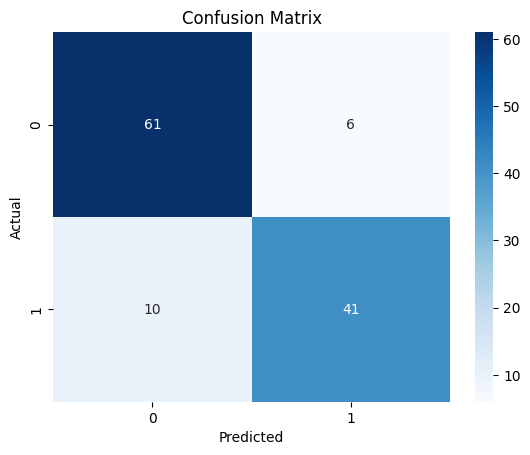

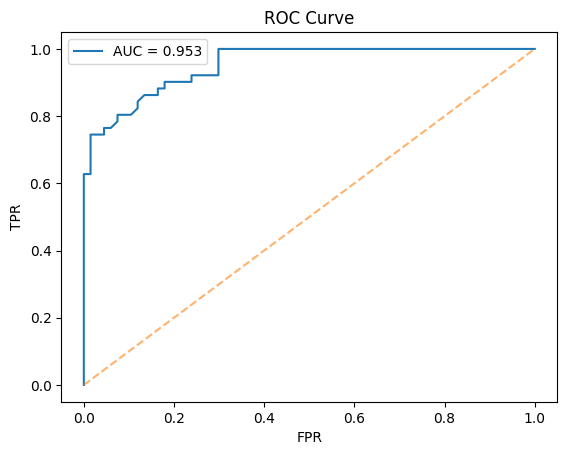

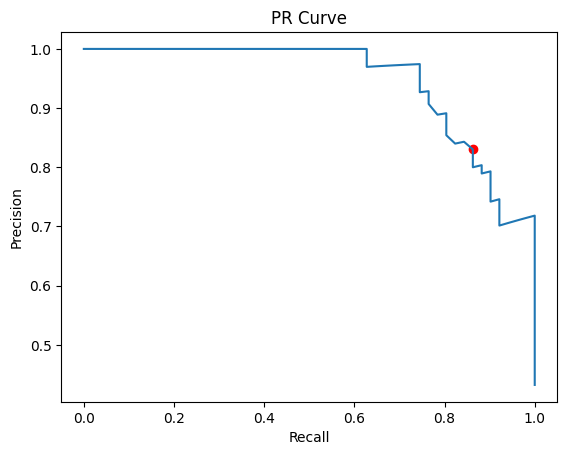

Best threshold: 0.369 → F1: 0.846


In [ ]:
# Cell 7: Evaluation Metrics
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, zero_division=0)
rec = recall_score(y_val, y_pred, zero_division=0)
f1 = f1_score(y_val, y_pred, zero_division=0)
print(f"Accuracy:  {acc:.3f}\nPrecision: {prec:.3f}\nRecall:    {rec:.3f}\nF1 Score:  {f1:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix'); plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',alpha=0.6)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

# PR Curve & Optimal Threshold
precs, recs, threshs = precision_recall_curve(y_val, y_prob)
f1s = 2 * (precs * recs) / (precs + recs)
best_idx = np.argmax(f1s)
plt.plot(recs, precs)
plt.scatter(recs[best_idx], precs[best_idx], color='red')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve'); plt.show()

print(f"Best threshold: {threshs[best_idx]:.3f} → F1: {f1s[best_idx]:.3f}")

In [ ]:
# Cell 8: Predict on New SMILES
new_smiles = [  # Actives (SGLT2 inhibitors)
    "CCOc1ccc(cc1)Cc1cc(ccc1Cl)C1OC(CO)C(O)C(O)C1O",  # Dapagliflozin
    "CC1=CC(=O)N(C(=O)C2=CC(=C(C=C2)C(F)(F)F)S(=O)(=O)NC3=CC=C(C=C3)F)C(C)(C)C1",  # Canagliflozin
    "CC1C(C(C(C(O1)OC2=CC=C(C=C2)OC3=CC=C(C=C3)Cl)O)O)O[C@H]4CC[C@@H]([C@H](O4)C#N)O",  # Empagliflozin
    "CC1C(C(C(C(O1)OC2=CC(=C(C=C2)F)Cl)O)O)O[C@H]3CC[C@@H]([C@H](O3)C#N)O",  # Ertugliflozin
    "CCOC1=CC=C(C=C1)CC2=C(C=CC(=C2)[C@H]3[C@@H]([C@H]([C@@H]([C@H](O3)CO)O)O)O)Cl",  # Sotagliflozin

    # Decoys (simple organics)
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",  # Caffeine
    "CC(=O)OC1=CC=CC=C1C(=O)O",  # Aspirin
    "CC(=O)NC1=CC=C(O)C=C1",  # Acetaminophen
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # Ibuprofen
    "C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)O"]
new_X = np.vstack([smiles_to_fp_bits(s) for s in new_smiles])
new_prob = best_model.predict_proba(new_X)[:, 1]
new_pred = best_model.predict(new_X)

labels = ["Dapagliflozin", "Canagliflozin", "Empagliflozin","Ertugliflozin","Sotagliflozin","Caffeine","Aspirin","Acetaminophen","Ibuprofen","Glucose"]
for label, prob, pred in zip(labels, new_prob, new_pred):
    print(f"{label}: P(Active) = {prob:.3f} → {pred}")

Dapagliflozin: P(Active) = 0.126 → 0
Canagliflozin: P(Active) = 0.316 → 0
Empagliflozin: P(Active) = 0.634 → 1
Ertugliflozin: P(Active) = 0.646 → 1
Sotagliflozin: P(Active) = 0.126 → 0
Caffeine: P(Active) = 0.566 → 1
Aspirin: P(Active) = 0.736 → 1
Acetaminophen: P(Active) = 0.605 → 1
Ibuprofen: P(Active) = 0.463 → 0
Glucose: P(Active) = 0.382 → 0
